# Loading data from Simulations

In [1]:
import os
import re
import pandas as pd
import numpy as np
from io import StringIO

input_folder_name = "Step5" # folder name within data/cluster/endsim
output_folder_name = input_folder_name

# Updated regex pattern to handle all cases
pattern = r"EndSim_epsM(-?[\d\.]+)_epsSD(-?[\d\.]+)___OpDnormal_OpM(-?[\d\.]+)_OpSD(-?[\d\.]+)___NetScale-free___NAgents(\d+)___RS\d+__MedInfF([\d\.]+)___MedDdeterministic-normal_MedN(\d+)_MedM(-?[\d\.]+)_MedSD(-?[\d\.]+)"

def parse_filename(filename):
    """Extract parameters from filename using regex"""
    # Remove .csv extension before parsing
    base_name = os.path.splitext(filename)[0]
    match = re.search(pattern, base_name)
    
    if match:
        return {
            'epsM': float(match.group(1)),
            'epsSD': float(match.group(2)),
            'OpM': float(match.group(3)),
            'OpSD': float(match.group(4)),
            'NAgents': int(match.group(5)),  # Convert to integer
            'MedInfF': float(match.group(6)),  # New Influence Factor parameter
            'MedN': int(match.group(7)),      # Convert to integer
            'MedM': float(match.group(8)),
            'MedSD': float(match.group(9))
        }
    return None
    
def extract_opinion_sections(content):
    """Extract media and individual opinion sections from file content"""
    # Split content into sections using separator lines
    sections = re.split(r'-{10,}', content)
    
    # We expect at least 4 sections:
    # 0: Metadata
    # 1: Network connections (skip)
    # 2: Media opinions
    # 3: Individual opinions
    if len(sections) < 4:
        return None, None
    
    # Extract media opinions section
    media_section = sections[2].strip()
    # Extract individual opinions section
    individual_section = sections[3].strip()
    
    return media_section, individual_section

def parse_opinion_section(section):
    """Parse a single opinion section into a DataFrame"""
    if not section:
        return pd.DataFrame()
    
    # Clean section by removing any empty lines and brackets
    cleaned_lines = []
    for line in section.split('\n'):
        if line.strip() and not line.startswith('[') and not line.startswith('--'):
            cleaned_lines.append(line)
    
    if not cleaned_lines:
        return pd.DataFrame()
    
    # Recreate CSV content
    csv_content = "\n".join(cleaned_lines)
    
    # Parse as CSV
    try:
        return pd.read_csv(StringIO(csv_content))
    except:
        return pd.DataFrame()

def process_simulation_file(filepath):
    """Process a single simulation file with section handling"""
    # Extract parameters from filename
    filename = os.path.basename(filepath)
    params = parse_filename(filename)
    if not params:
        print(f"Skipping {filename} - pattern not matched")
        return None
    
    try:
        # Read entire file content
        with open(filepath, 'r') as f:
            content = f.read()
        # Extract opinion sections
        media_section, individual_section = extract_opinion_sections(content)

        # Parse media opinions
        media_df = parse_opinion_section(media_section)

        media_opinions = []
        # print(media_df.columns)

        if not media_df.empty and ' opinion)' in media_df:
            media_opinions = media_df[' opinion)'].apply(
                lambda x: float(str(x).strip('[]'))).values
        
        # Parse individual opinions
        individual_df = parse_opinion_section(individual_section)
        individual_opinions = []
        if not individual_df.empty and 'opinion' in individual_df:
            individual_opinions = individual_df['opinion'].apply(
                lambda x: float(str(x).strip('[]'))).values

        
        individual_initial_opinions = []
        if not individual_df.empty and 'initialOpinion' in individual_df:
            individual_initial_opinions = individual_df['initialOpinion'].apply(
                lambda x: float(str(x).strip('[]'))).values
        
        # Add to params
        params['individual_opinions'] = np.array(individual_opinions)
        params['media_opinions'] = np.array(media_opinions)
        
        # Add static parameters
        params['NAgents'] = 1000
        params['MedN'] = 20
        params['NetType'] = "scale-free"
        params['ScaleFreeDegree'] = 1
        
        return params
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        return None

def load_all_simulations(directory):
    """Process all simulation files in a directory"""
    all_data = []
    processed_count = 0
    skipped_count = 0
    error_count = 0
    
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            result = process_simulation_file(filepath)
            if result:
                all_data.append(result)
                processed_count += 1
            else:
                skipped_count += 1
    
    print(f"Summary: Processed={processed_count}, Skipped={skipped_count}")
    return pd.DataFrame(all_data) if all_data else pd.DataFrame()

# Example usage
if __name__ == "__main__":
    simulations_df = load_all_simulations("data\\cluster\\endsim\\" + input_folder_name)
    
    if not simulations_df.empty:
        print(f"\nSuccessfully loaded {len(simulations_df)} simulations")
        print("Parameter ranges:")
        for param in ['epsM', 'epsSD', 'OpM', 'OpSD', 'MedM', 'MedSD']:
            values = simulations_df[param]
            print(f"{param}: min={values.min()}, max={values.max()}")
        
        # Show example opinion data
        sample = simulations_df.iloc[0]
        print(f"\nSample simulation opinions:")
        print(f"Individual opinions: {len(sample['individual_opinions'])} values")
        print(f"Media opinions: {len(sample['media_opinions'])} values")
    else:
        print("No simulations loaded. Please check file patterns and data quality.")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data\\cluster\\endsim\\Step5'

In [2]:
simulations_df

,epsM,epsSD,OpM,OpSD,NAgents,MedInfF,MedN,MedM,MedSD,individual_opinions,media_opinions,NetType,ScaleFreeDegree
0,0.01,0.05,0.0,0.3,1000,0.2,20,-0.5,0.3,"[-0.045, -0.021, 0.398, -0.041, -0.034, -0.076...","[-0.2275390625, -0.5343017578125, -0.395385742...",scale-free,1
1,0.01,0.05,0.0,0.3,1000,0.2,20,-0.5,0.6,"[0.008, -0.151, -0.201, 0.218, 0.177, -0.09, -...","[-0.431396484375, 0.044921875, -0.568603515625...",scale-free,1
2,0.01,0.05,0.0,0.3,1000,0.2,20,-0.5,0.9,"[-0.468, 0.009, 0.026, 0.008, 0.004, -0.018, 0...","[-0.397216796875, -1.0, 0.3173828125, -0.60278...",scale-free,1
3,0.01,0.05,0.0,0.3,1000,0.2,20,-0.5,0.0,"[-0.21499999999999997, 0.224, 0.061, -0.304, -...","[-0.5090866088867188, -0.4988594055175781, -0....",scale-free,1
4,0.01,0.05,0.0,0.3,1000,0.2,20,-1.0,0.3,"[0.049, -0.023, 0.166, 0.016, 0.411, -0.381, -...","[-1.0, -0.9656982421875, -0.818603515625, -0.8...",scale-free,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15356,0.15,0.00,0.0,0.0,1000,1.0,20,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00348663330078125, -0.001140594482421875, -...",scale-free,1
15357,0.15,0.00,0.0,0.0,1000,1.0,20,1.0,0.3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.818603515625, 0.599609375, 1.0, 1.0, 1...",scale-free,1
15358,0.15,0.00,0.0,0.0,1000,1.0,20,1.0,0.6,"[0.327, 0.327, 0.327, 0.327, 0.327, 0.327, 0.3...","[0.455078125, 1.0, 0.790771484375, 0.931396484...",scale-free,1
15359,0.15,0.00,0.0,0.0,1000,1.0,20,1.0,0.9,"[-0.009, -0.009, -0.009, -0.009, -0.009, -0.00...","[0.897216796875, 1.0, 1.0, 1.0, -0.201171875, ...",scale-free,1


## Binning Simulation Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin edges for 10-point scale mapping
bin_edges = np.array([-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Create bin interval labels for display
bin_intervals = [
    "[-1.0, -0.8)",
    "[-0.8, -0.6)",
    "[-0.6, -0.4)",
    "[-0.4, -0.2)",
    "[-0.2, 0.0)",
    "[0.0, 0.2)",
    "[0.2, 0.4)",
    "[0.4, 0.6)",
    "[0.6, 0.8)",
    "[0.8, 1.0]"
]

def bin_opinions(opinions):
    """Bin opinions into 10-point scale categories"""
    # Digitize opinions (returns bin indices 1-10)
    bin_indices = np.digitize(opinions, bin_edges[1:-1], right=False)
    return bin_indices

def bin_distribution(opinions):
    """Compute normalized distribution across bins"""
    counts, _ = np.histogram(opinions, bins=bin_edges)
    return counts / counts.sum()

# Add binned opinions and distributions to DataFrame
simulations_df['binned_opinions'] = simulations_df['individual_opinions'].apply(
    lambda x: bin_opinions(np.array(x))
)

simulations_df['binned_distribution'] = simulations_df['individual_opinions'].apply(
    lambda x: bin_distribution(np.array(x))
)

# Add bin interval labels as a constant column
simulations_df['bin_intervals'] = [bin_intervals] * len(simulations_df)

# Display the updated DataFrame
print("\nDataFrame with binned opinions:")
print(simulations_df[['epsM', 'epsSD', 'OpM', 'OpSD', 'MedM', 'MedSD', 
                      'binned_opinions', 'binned_distribution', 'bin_intervals']].head())


DataFrame with binned opinions:
   epsM  epsSD  OpM  OpSD  MedM  MedSD  \
0  0.01   0.05  0.0   0.3  -0.5    0.3   
1  0.01   0.05  0.0   0.3  -0.5    0.6   
2  0.01   0.05  0.0   0.3  -0.5    0.9   
3  0.01   0.05  0.0   0.3  -0.5    0.0   
4  0.01   0.05  0.0   0.3  -1.0    0.3   

                                     binned_opinions  \
0  [4, 4, 6, 4, 4, 4, 4, 1, 4, 5, 4, 4, 4, 4, 4, ...   
1  [5, 4, 3, 6, 5, 4, 4, 8, 4, 5, 4, 4, 5, 7, 6, ...   
2  [2, 5, 5, 5, 5, 4, 5, 5, 4, 7, 4, 4, 4, 6, 4, ...   
3  [3, 6, 5, 3, 3, 7, 7, 4, 8, 4, 5, 3, 4, 6, 4, ...   
4  [5, 4, 5, 5, 7, 3, 4, 3, 4, 2, 6, 4, 5, 3, 4, ...   

                                 binned_distribution  \
0  [0.001, 0.001, 0.008, 0.03, 0.533, 0.173, 0.15...   
1  [0.001, 0.006, 0.013, 0.061, 0.433, 0.331, 0.0...   
2  [0.002, 0.004, 0.019, 0.083, 0.342, 0.406, 0.0...   
3  [0.007, 0.016, 0.013, 0.136, 0.343, 0.228, 0.1...   
4  [0.001, 0.004, 0.043, 0.177, 0.294, 0.225, 0.1...   

                                       b

## Pooled Sim Data Histogram


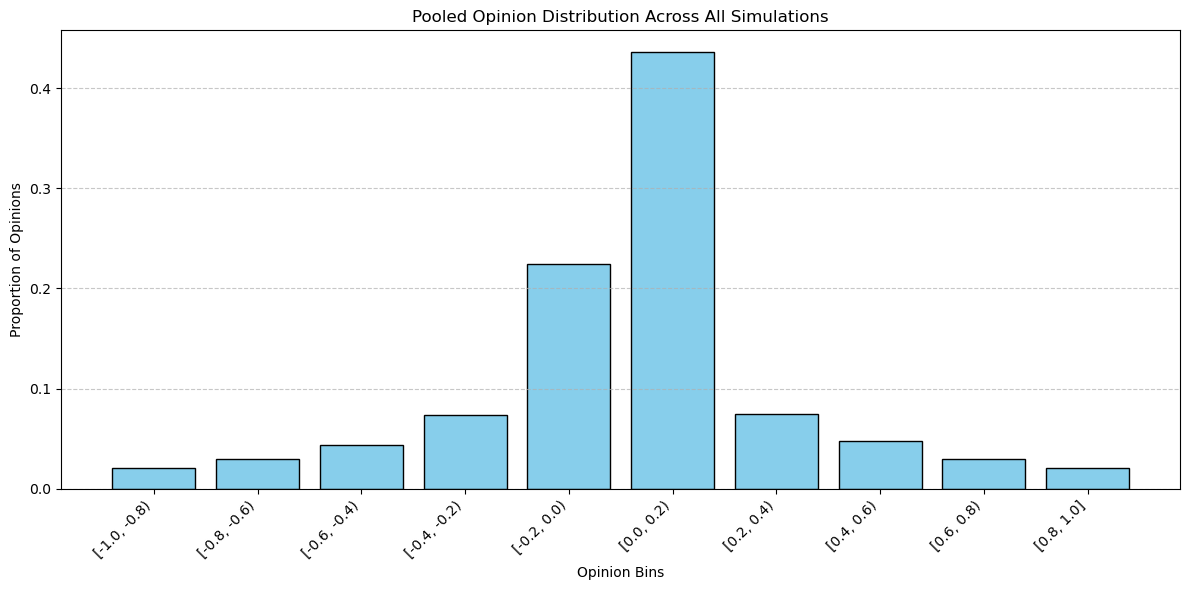

In [4]:
# Create pooled histogram of all opinions
all_opinions = np.concatenate(simulations_df['individual_opinions'].values)
pooled_counts, _ = np.histogram(all_opinions, bins=bin_edges)
pooled_distribution = pooled_counts / pooled_counts.sum()

# Plot the pooled histogram
plt.figure(figsize=(12, 6))
plt.bar(range(1, 11), pooled_distribution, color='skyblue', edgecolor='black')
plt.xticks(range(1, 11), bin_intervals, rotation=45, ha='right')
plt.xlabel('Opinion Bins')
plt.ylabel('Proportion of Opinions')
plt.title('Pooled Opinion Distribution Across All Simulations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('pooled_opinion_distribution.png', dpi=300)
plt.show()


## Generate individual histograms for every run

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Create output directory
output_dir = "analysis/plots/endsim_distributions/" + output_folder_name
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Define bin edges and labels
bin_edges = np.array([-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
bin_intervals = [
    "[-1.0, -0.8)", "[-0.8, -0.6)", "[-0.6, -0.4)", "[-0.4, -0.2)", 
    "[-0.2, 0.0)", "[0.0, 0.2)", "[0.2, 0.4)", "[0.4, 0.6)", 
    "[0.6, 0.8)", "[0.8, 1.0]"
]

# Function to create and save histograms
def save_simulation_histogram(row, index):
    """Create and save histogram for a single simulation"""
    # Extract parameters for title and filename
    params = {
        'epsM': row['epsM'],
        'epsSD': row['epsSD'],
        'OpM': row['OpM'],
        'OpSD': row['OpSD'],
        'MedM': row['MedM'],
        'MedSD': row['MedSD'],
        'MedInfF': row['MedInfF']
    }
    
    # Create filename with parameters
    filename = (
        f"sim_{index:04d}_"
        f"epsM{params['epsM']:.2f}_epsSD{params['epsSD']:.2f}_"
        f"OpM{params['OpM']:.2f}_OpSD{params['OpSD']:.2f}_"
        f"MedM{params['MedM']:.2f}_MedSD{params['MedSD']:.2f}__"
        f"MedInf{params['MedInfF']:.2f}.png"
    ).replace(".", "dot")  # Replace dots to avoid filesystem issues
    
    # Create title with parameters
    title = (
        f"Final Opinion Distribution: "
        f"εμ={params['epsM']:.2f}, εσ={params['epsSD']:.2f}, "
        f"Opμ={params['OpM']:.2f}, Opσ={params['OpSD']:.2f}, "
        f"Medμ={params['MedM']:.2f}, Medσ={params['MedSD']:.2f}, "
        f"MedInfF={params['MedInfF']:.2f}"
    )
    
    # Create figure
    plt.figure(figsize=(12, 7))
    
    # Plot histogram
    n, bins, patches = plt.hist(
        row['individual_opinions'], 
        bins=bin_edges, 
        density=False, 
        alpha=0.7, 
        color='steelblue',
        edgecolor='black'
    )

    # Add vertical lines at media positions for reference
    for medop in row['media_opinions']:
        plt.axvline(medop, color='red', linestyle='--', alpha=0.5)
    
    # Format plot
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Opinion Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(bin_edges, rotation=45)
    plt.xlim(-1.05, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add bin labels
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    for i in range(len(bin_intervals)):
        plt.text(
            bin_centers[i], n[i] + 0.01, 
            f"{n[i]:.2f}\n{bin_intervals[i]}", 
            ha='center', va='bottom', fontsize=9
        )
    
    # Add statistics box
    stats_text = (
        f"N: {len(row['individual_opinions'])}\n"
    )
    
    plt.gcf().text(0.95, 0.85, stats_text, fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.5))
    
    # Save and close
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), dpi=150)
    plt.close()
    return filename

# Generate histograms for all simulations
print(f"Generating {len(simulations_df)} histograms...")
for i, (index, row) in enumerate(simulations_df.iterrows()):
    if i % 100 == 0:  # Print progress every 100 files
        print(f"Processing simulation {i+1}/{len(simulations_df)}")
    save_simulation_histogram(row, index)

print(f"\nAll histograms saved to: {output_dir}")

Generating 15361 histograms...
Processing simulation 1/15361


In [6]:
output_dir

'analysis/plots/endsim_distributions/QS_2'

## New column to club 5 and 6

There is anchoring at 5 in the parlemeter data, even though the mathematical center is at 5.5. This is obviously not captured in the model data, so we can try and club the 5 and 6.

In [5]:
simulations_df['binned_distributions_5_6clubbed'] = simulations_df['binned_distribution'].apply(
    lambda dist: np.concatenate([dist[:4], [dist[4] + dist[5]], dist[6:]])
)
# for i, (index, row) in enumerate(simulations_df.iterrows()):
#     binned_dist = list(row['binned_distribution'])
#     clubbed_dist = binned_dist[:4] + [binned_dist[4] + binned_dist[5]] + binned_dist[6:]
#     simulations_df.append({"binned_distribution_5_6clubbed": clubbed_dist})

In [6]:
print(simulations_df)
print(simulations_df["binned_distributions_5_6clubbed"].iloc[0])

       epsM  epsSD  OpM  OpSD  NAgents  MedInfF  MedN  MedM  MedSD  \
0      0.01   0.05  0.0   0.3     1000      0.2    20  -0.5    0.3   
1      0.01   0.05  0.0   0.3     1000      0.2    20  -0.5    0.6   
2      0.01   0.05  0.0   0.3     1000      0.2    20  -0.5    0.9   
3      0.01   0.05  0.0   0.3     1000      0.2    20  -0.5    0.0   
4      0.01   0.05  0.0   0.3     1000      0.2    20  -1.0    0.3   
...     ...    ...  ...   ...      ...      ...   ...   ...    ...   
15356  0.15   0.00  0.0   0.0     1000      1.0    20   0.0    0.0   
15357  0.15   0.00  0.0   0.0     1000      1.0    20   1.0    0.3   
15358  0.15   0.00  0.0   0.0     1000      1.0    20   1.0    0.6   
15359  0.15   0.00  0.0   0.0     1000      1.0    20   1.0    0.9   
15360  0.15   0.00  0.0   0.0     1000      1.0    20   1.0    0.0   

                                     individual_opinions  \
0      [-0.045, -0.021, 0.398, -0.041, -0.034, -0.076...   
1      [0.008, -0.151, -0.201, 0.218, 0

In [7]:
simulations_df['OpM'].unique()

array([0.])

# Load Survey Data.

In [8]:
import os


# Set up paths
folder_path = "data/EU_dataset"
file_title = "Cleaned_Parlemeter_Data-LeftRight"
file_name = file_title + ".xlsx"
survey_file = os.path.join(folder_path, file_name)

sheets = pd.ExcelFile(survey_file).sheet_names[1:]  # Skip 'RowHeaders'

survey_data = []

for sheet in sheets:
    country = sheet.split("-")[0]  # Extract country code (e.g., "BE")
    df_sheet = pd.read_excel(survey_file, sheet_name=sheet, header=None)
    
    # Years are in the first row
    years = df_sheet.iloc[0, :].tolist()
    
    # Extract counts for positions 1-10 (skip % rows and DK/Refusal)
    counts_matrix = []
    for i in range(10):  # Positions 1-10
        row_index = 1 + 2 * i  # Count rows are at indices 1,3,5,...,19
        counts_matrix.append(df_sheet.iloc[row_index, :].tolist())
    
    # Process each year
    for j, year in enumerate(years):
        counts = [float(counts_matrix[i][j]) for i in range(10)]
        total_valid = sum(counts)
        
        # Normalized distribution (1-10)
        distribution = [c / total_valid for c in counts]

        # Pool bins 5 and 6
        pooled_counts = counts[:4] + [counts[4] + counts[5]] + counts[6:]
        pooled_distribution = [c / total_valid for c in pooled_counts]
        
        survey_data.append({
            "country": country,
            "year": int(year),
            "binned_distribution": distribution,
            "binned_distribution_5_6clubbed": pooled_distribution,
            "total_respondents": total_valid
        })
survey_df = pd.DataFrame(survey_data)

In [9]:
survey_df

,country,year,binned_distribution,binned_distribution_5_6clubbed,total_respondents
0,BE,2007,"[0.03948772678762007, 0.030949839914621132, 0....","[0.03948772678762007, 0.030949839914621132, 0....",937.0
1,BE,2010,"[0.04880694143167028, 0.04121475054229935, 0.0...","[0.04880694143167028, 0.04121475054229935, 0.0...",922.0
2,BE,2012,"[0.03479125248508946, 0.040755467196819085, 0....","[0.03479125248508946, 0.040755467196819085, 0....",1006.0
3,BE,2014,"[0.06989247311827956, 0.02795698924731183, 0.1...","[0.06989247311827956, 0.02795698924731183, 0.1...",930.0
4,BE,2015,"[0.035343035343035345, 0.033264033264033266, 0...","[0.035343035343035345, 0.033264033264033266, 0...",962.0
...,...,...,...,...,...
227,UK,2014,"[0.039250669045495096, 0.06155218554861731, 0....","[0.039250669045495096, 0.06155218554861731, 0....",1121.0
228,UK,2015,"[0.04514480408858603, 0.05536626916524702, 0.1...","[0.04514480408858603, 0.05536626916524702, 0.1...",1174.0
229,UK,2016,"[0.022279348757497857, 0.06683804627249357, 0....","[0.022279348757497857, 0.06683804627249357, 0....",1167.0
230,UK,2017,"[0.0008090614886731392, 0.0703883495145631, 0....","[0.0008090614886731392, 0.0703883495145631, 0....",1236.0


In [32]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon

# Ensure vectors are numpy arrays of floats
def to_array(x):
    return np.array(x, dtype=float)

# Expand the data into all pairs
results = []

for sim_idx, sim_row in simulations_df.iterrows():
    sim_dist = to_array(sim_row['binned_distributions_5_6clubbed'])
    
    for surv_idx, surv_row in survey_df.iterrows():
        surv_dist = to_array(surv_row['binned_distribution_5_6clubbed'])
        
        # Jensen–Shannon divergence
        jsd = jensenshannon(sim_dist, surv_dist)  # already returns sqrt(JS divergence)
        
        results.append({
            'sim_index': sim_idx,
            'country': surv_row['country'],
            'year': surv_row['year'],
            'epsM': sim_row['epsM'],
            'epsSD': sim_row['epsSD'],
            'OpM': sim_row['OpM'],
            'OpSD': sim_row['OpSD'],
            'MedM': sim_row['MedM'],
            'MedSD': sim_row['MedSD'],
            'MedInfF': sim_row['MedInfF'],
            'distance': jsd
        })

results_df = pd.DataFrame(results)

# Find best fits per country-year
best_fits = results_df.sort_values('distance').groupby(['country', 'year']).head(5)


KeyboardInterrupt: 

In [34]:
print(best_fits)

         sim_index country  year  epsM  epsSD  OpM  OpSD  MedM  MedSD  \
364268        1570      DK  2015  0.01   0.00  0.0   0.6   0.5    0.9   
2866195      12354      IE  2014  0.13   0.15  0.0   0.9   0.0    0.6   
496740        2141      DK  2015  0.03   0.05  0.0   0.6  -0.5    0.6   
3423001      14754      EL  2010  0.15   0.10  0.0   0.9   0.0    0.6   
2504281      10794      EL  2010  0.11   0.10  0.0   0.6   0.0    0.6   
...            ...     ...   ...   ...    ...  ...   ...   ...    ...   
1520955       6555      SI  2014  0.07   0.15  0.0   0.9   0.0    0.0   
2416707      10416      SI  2014  0.11   0.15  0.0   0.9   0.0    0.0   
1752636       7554      CY  2015  0.07   0.00  0.0   0.9   0.0    0.9   
2728196      11759      CY  2015  0.13   0.05  0.0   0.6   1.0    0.9   
1724796       7434      CY  2015  0.07   0.00  0.0   0.6   0.0    0.9   

         MedInfF  distance  
364268       0.2  0.034841  
2866195      1.0  0.034867  
496740       1.0  0.035079  
3423001

In [35]:
(best_fits.nsmallest(60, 'distance'))

,sim_index,country,year,epsM,epsSD,OpM,OpSD,MedM,MedSD,MedInfF,distance
364268,1570,DK,2015,0.01,0.00,0.0,0.6,0.5,0.9,0.2,0.034841
2866195,12354,IE,2014,0.13,0.15,0.0,0.9,0.0,0.6,1.0,0.034867
496740,2141,DK,2015,0.03,0.05,0.0,0.6,-0.5,0.6,1.0,0.035079
3423001,14754,EL,2010,0.15,0.10,0.0,0.9,0.0,0.6,1.0,0.036292
2504281,10794,EL,2010,0.11,0.10,0.0,0.6,0.0,0.6,1.0,0.037083
2977551,12834,EE,2019,0.13,0.10,0.0,0.9,0.0,0.6,1.0,0.037293
370532,1597,DK,2015,0.01,0.00,0.0,0.6,1.0,0.6,0.4,0.038440
384452,1657,DK,2015,0.01,0.00,0.0,0.6,1.0,0.6,0.0,0.038641
1501809,6473,EL,2010,0.07,0.15,0.0,0.6,0.0,0.6,1.0,0.039077
365892,1577,DK,2015,0.01,0.00,0.0,0.6,1.0,0.6,0.2,0.039266


In [39]:
simulations_df['epsM'].unique()

array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15])

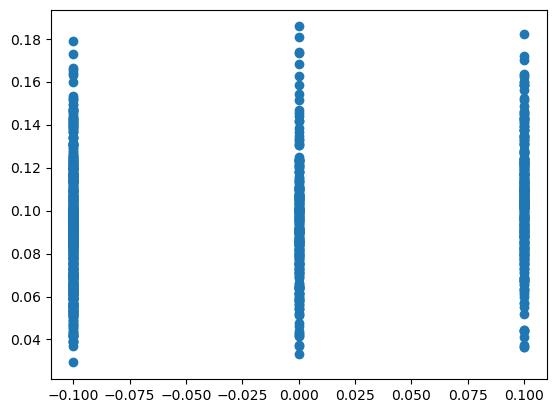

In [15]:
plt.figure()
plt.scatter(best_fits['OpM'], best_fits['distance'])

Text(0.5, 1.0, 'Epsilon SD')

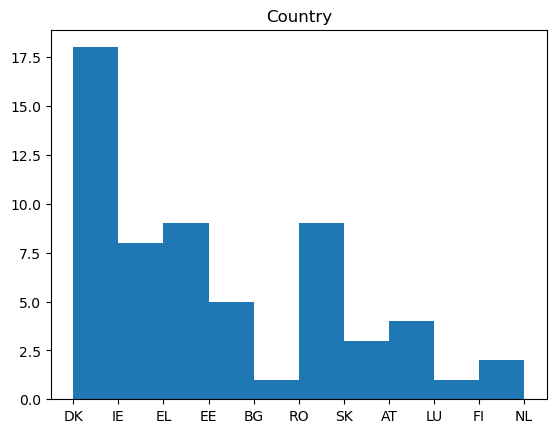

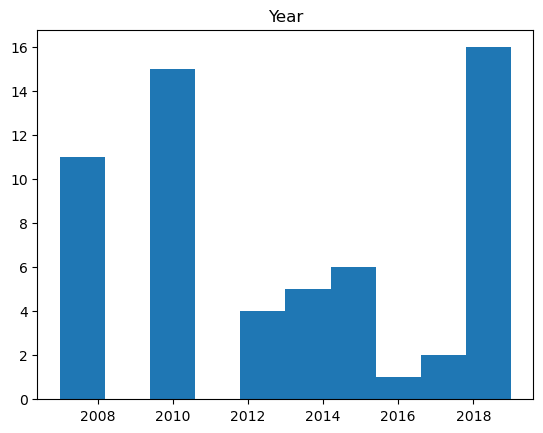

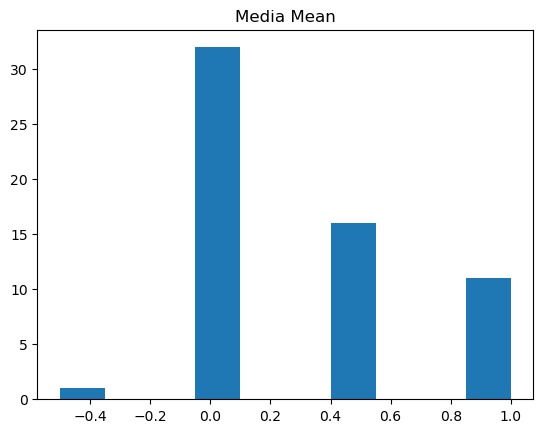

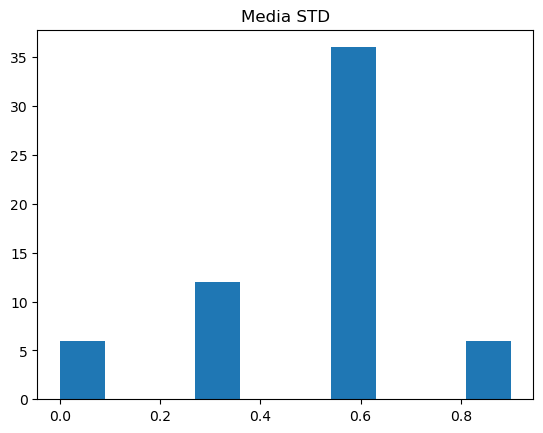

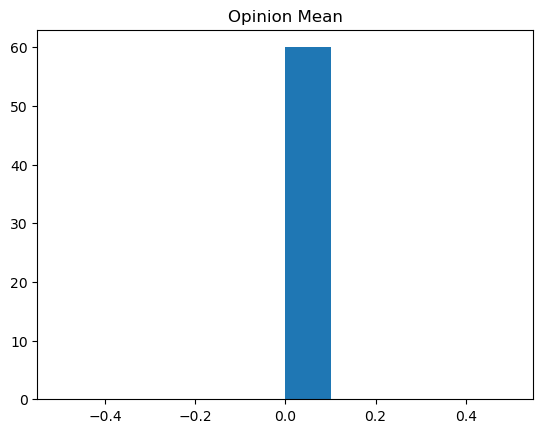

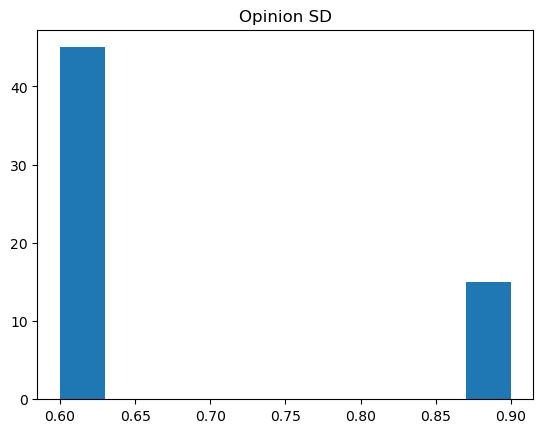

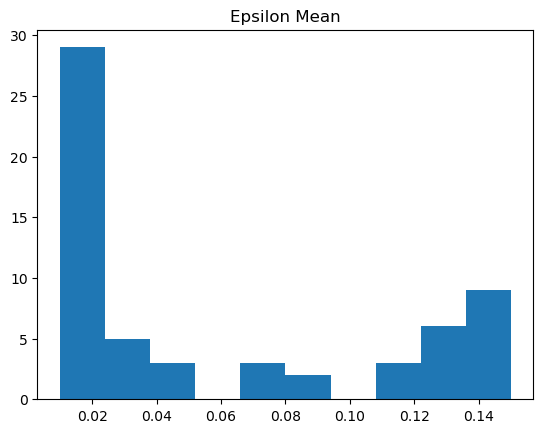

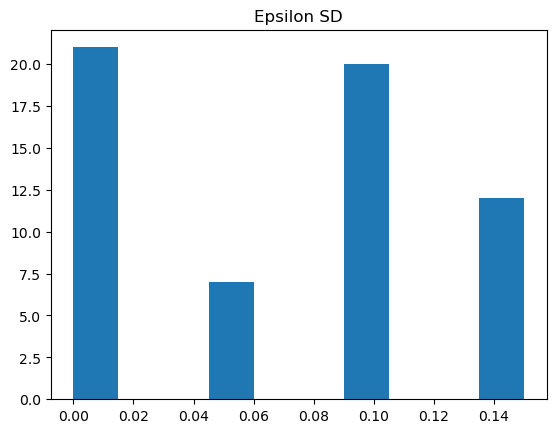

In [13]:
# Taking the set of k best fits to see if there's a systematic effect of any of the variables
k_smallest = (best_fits.nsmallest(60, 'distance'))

#Plotting histograms of some variable among these runs (and assuming a uniformity therein) to see if there are any biases
plt.figure()
plt.hist(k_smallest['country'], align = 'mid')
plt.title("Country")
plt.figure()
plt.hist(k_smallest['year'])
plt.title("Year")
plt.figure()
plt.hist(k_smallest['MedM'])
plt.title("Media Mean")
plt.figure()
plt.hist(k_smallest['MedSD'])
plt.title("Media STD")
plt.figure()
plt.hist(k_smallest['OpM'])
plt.title("Opinion Mean")
plt.figure()
plt.hist(k_smallest['OpSD'])
plt.title("Opinion SD")
plt.figure()

plt.hist(k_smallest['epsM'])
plt.title("Epsilon Mean")
plt.figure()

plt.hist(k_smallest['epsSD'])
plt.title("Epsilon SD")

         sim_index country  year  epsM  epsSD  OpM  OpSD  MedM  MedSD  \
1724796       7434      CY  2015  0.07   0.00  0.0   0.6   0.0    0.9   
2728196      11759      CY  2015  0.13   0.05  0.0   0.6   1.0    0.9   
1752636       7554      CY  2015  0.07   0.00  0.0   0.9   0.0    0.9   
2416707      10416      SI  2014  0.11   0.15  0.0   0.9   0.0    0.0   
1520955       6555      SI  2014  0.07   0.15  0.0   0.9   0.0    0.0   
2412067      10396      SI  2014  0.11   0.15  0.0   0.9   0.0    0.0   
2421347      10436      SI  2014  0.11   0.15  0.0   0.9   0.0    0.0   
637499        2747      SI  2014  0.03   0.15  0.0   0.9  -1.0    0.0   
1307196       5634      CY  2015  0.05   0.00  0.0   0.9   0.0    0.9   
1976282       8518      CY  2012  0.09   0.15  0.0   0.9   1.0    0.9   
636712        2744      CY  2007  0.03   0.15  0.0   0.9  -1.0    0.3   
1193512       5144      CY  2007  0.05   0.10  0.0   0.9  -1.0    0.3   
637414        2747      CY  2017  0.03   0.15  0.0 

Text(0.5, 1.0, 'e SD')

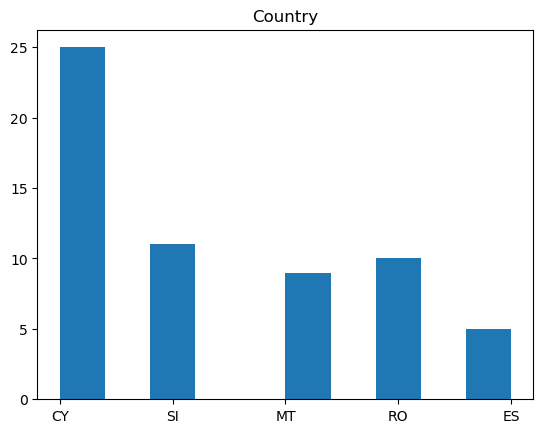

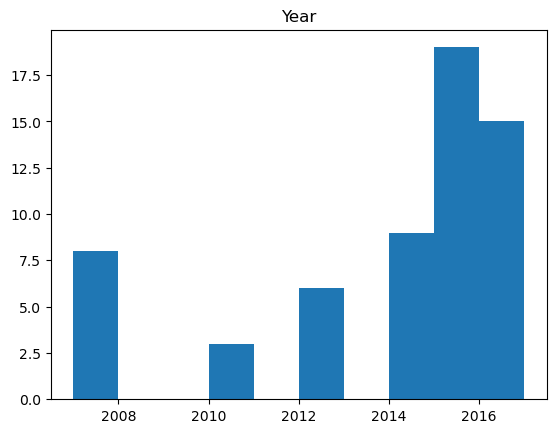

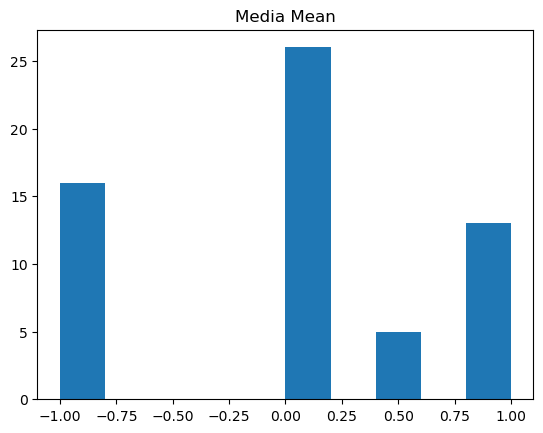

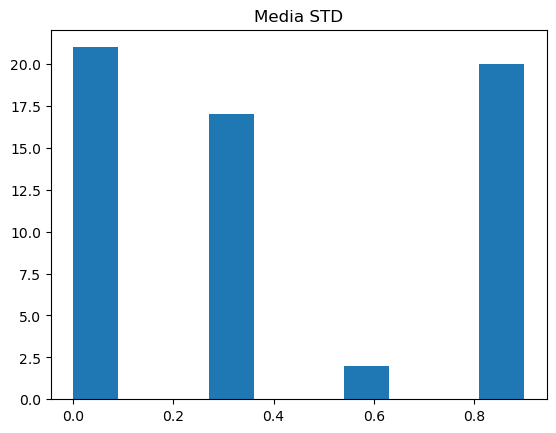

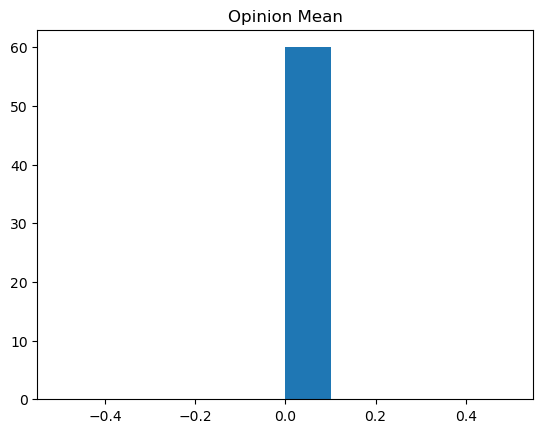

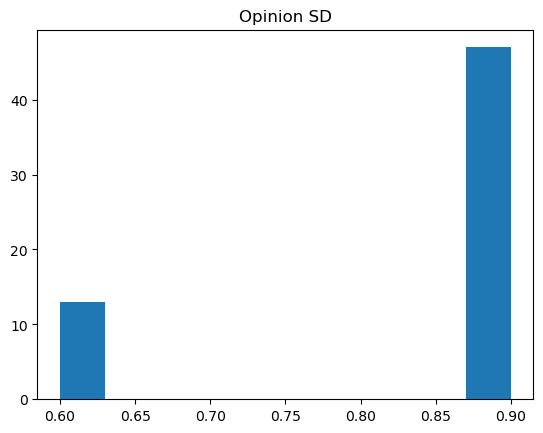

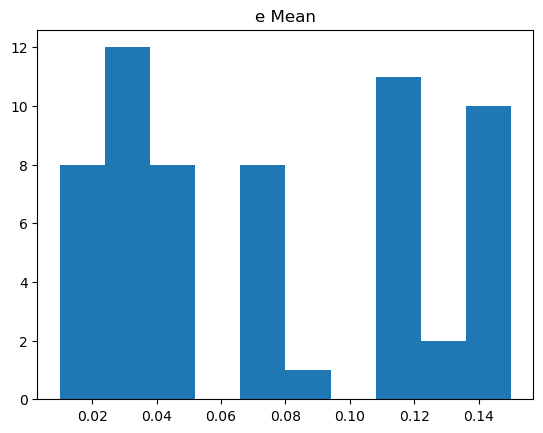

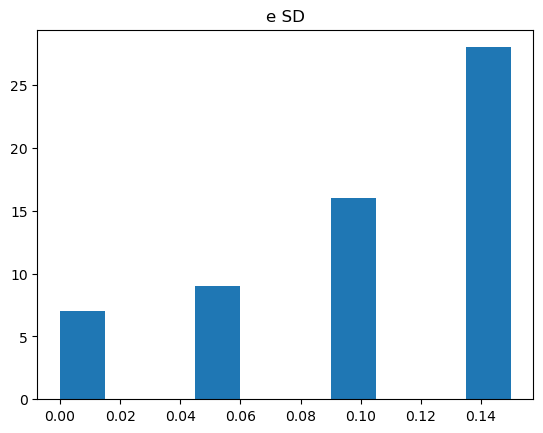

In [14]:
# Taking the set of k best fits to see if there's a systematic effect of any of the variables
k_largest = (best_fits.nlargest(60, 'distance'))
print(k_largest)
#Plotting histograms of some variable among these runs (and assuming a uniformity therein) to see if there are any biases
plt.figure()
plt.hist(k_largest['country'], align = 'mid')
plt.title("Country")
plt.figure()
plt.hist(k_largest['year'])
plt.title("Year")
plt.figure()
plt.hist(k_largest['MedM'])
plt.title("Media Mean")
plt.figure()
plt.hist(k_largest['MedSD'])
plt.title("Media STD")
plt.figure()
plt.hist(k_largest['OpM'])
plt.title("Opinion Mean")
plt.figure()
plt.hist(k_largest['OpSD'])
plt.title("Opinion SD")

plt.figure()
plt.hist(k_largest['epsM'])
plt.title("e Mean")
plt.figure()
plt.hist(k_largest['epsSD'])
plt.title("e SD")
plt.hist(k_largest['MedInfF'])
plt.title("Media Inf Factor")

ValueError: Axis limits cannot be NaN or Inf

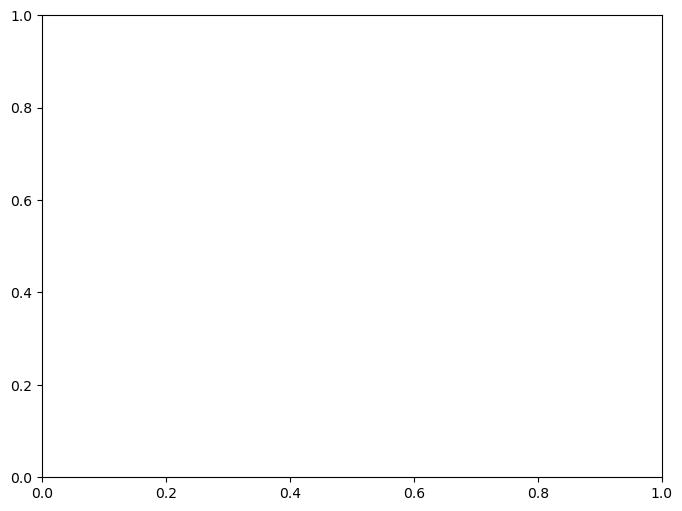

In [15]:
# Color plot to a selected country and year

import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

# Select target survey distribution
country = "BE"
year = 2010

survey_row = survey_df[(survey_df['country'] == country) & 
                       (survey_df['year'] == year)].iloc[0]
survey_dist = np.array(survey_row['binned_distribution_5_6clubbed'], dtype=float)

# Compute distances for all simulations
distances = []
for idx, row in simulations_df.iterrows():
    sim_dist = np.array(row['binned_distributions_5_6clubbed'], dtype=float)
    dist = jensenshannon(sim_dist, survey_dist)
    distances.append(dist)

simulations_df['distance'] = distances

# Example heatmap: epsM vs epsSD, fixing MedM and MedSD
fixed_MedM = 0.0
fixed_MedSD = 0.25

subset = simulations_df[(simulations_df['MedM'] == fixed_MedM) &
                         (simulations_df['MedSD'] == fixed_MedSD)]

pivot = subset.pivot_table(index='epsM', columns='epsSD', values='distance')

plt.figure(figsize=(8,6))
im = plt.imshow(pivot.values, origin='lower', 
                extent=[pivot.columns.min(), pivot.columns.max(), 
                        pivot.index.min(), pivot.index.max()],
                aspect='auto', cmap='viridis_r')
plt.colorbar(im, label='Jensen–Shannon distance')
plt.xlabel('epsSD')
plt.ylabel('epsM')
plt.title(f'Distance map: {country} {year} | MedM={fixed_MedM}, MedSD={fixed_MedSD}')
plt.show()


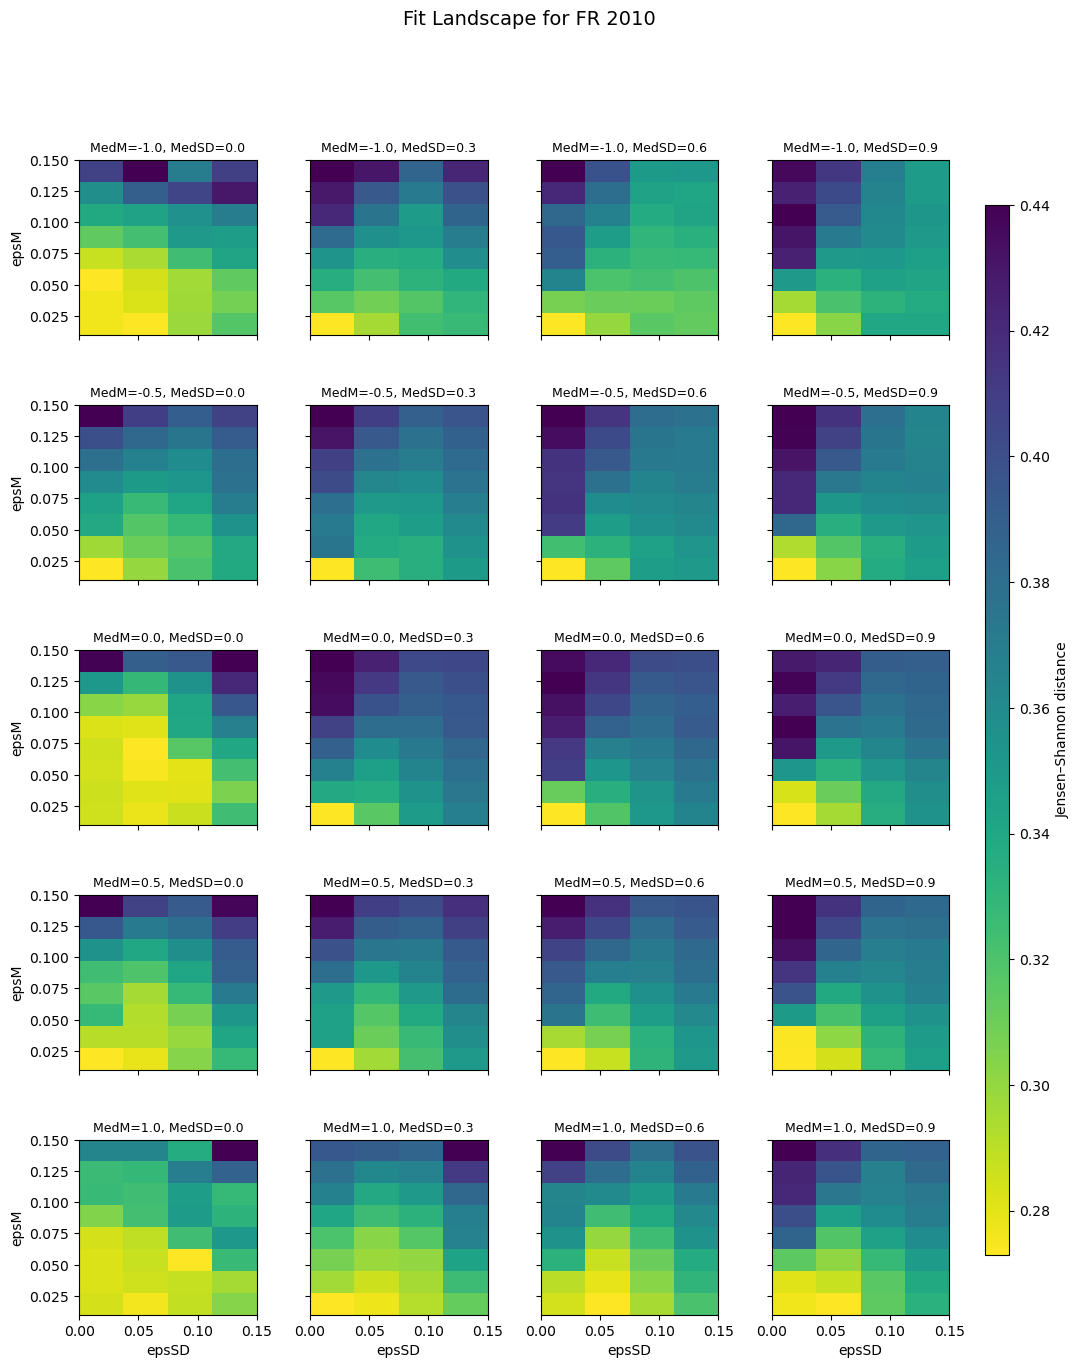

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from pathlib import Path

# Create output directory
output_dir = "analysis/plots/endsim_colorplots/" + output_folder_name
Path(output_dir).mkdir(parents=True, exist_ok=True)


# ---- Select target survey distribution ----
country = "FR"
year = 2010
survey_row = survey_df[(survey_df['country'] == country) & 
                       (survey_df['year'] == year)].iloc[0]
survey_dist = np.array(survey_row['binned_distribution_5_6clubbed'], dtype=float)

# ---- Compute distances for all simulations ----
distances = []
for idx, row in simulations_df.iterrows():
    sim_dist = np.array(row['binned_distributions_5_6clubbed'], dtype=float)
    dist = jensenshannon(sim_dist, survey_dist)
    distances.append(dist)

simulations_df['distance'] = distances

# ---- Get unique sorted parameter values ----
medM_vals = sorted(simulations_df['MedM'].unique())
medSD_vals = sorted(simulations_df['MedSD'].unique())

# ---- Set up subplot grid ----
fig, axes = plt.subplots(len(medM_vals), len(medSD_vals), 
                         figsize=(3*len(medSD_vals), 3*len(medM_vals)),
                         sharex=True, sharey=True)

if len(medM_vals) == 1 and len(medSD_vals) == 1:
    axes = np.array([[axes]])  # force 2D array for indexing
elif len(medM_vals) == 1:
    axes = axes[np.newaxis, :]
elif len(medSD_vals) == 1:
    axes = axes[:, np.newaxis]

# ---- Loop over panels ----
for i, medM in enumerate(medM_vals):
    for j, medSD in enumerate(medSD_vals):
        ax = axes[i, j]
        subset = simulations_df[(simulations_df['MedM'] == medM) &
                                (simulations_df['MedSD'] == medSD)]
        
        pivot = subset.pivot_table(index='epsM', columns='epsSD', values='distance')
        im = ax.imshow(pivot.values, origin='lower',
                       extent=[pivot.columns.min(), pivot.columns.max(), 
                               pivot.index.min(), pivot.index.max()],
                       aspect='auto', cmap='viridis_r')
        
        if i == len(medM_vals)-1:
            ax.set_xlabel('epsSD')
        if j == 0:
            ax.set_ylabel('epsM')
        ax.set_title(f"MedM={medM}, MedSD={medSD}", fontsize=9)

# ---- Add colorbar ----
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.4)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Jensen–Shannon distance')

plt.suptitle(f"Fit Landscape for {country} {year}", fontsize=14)
plt.savefig("colorplot.png",dpi=200)
plt.show()


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from pathlib import Path
import os

# Create output directory
output_dir = "analysis/plots/endsim_colorplots/" + output_folder_name
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Function to find best fit for each parameter combination
def find_best_fit(simulations_df, survey_df):
    best_fits = []
    
    # Iterate through all parameter combinations
    for (epsM, epsSD, OpM, OpSD, MedInfF, MedM, MedSD), group in simulations_df.groupby([
        'epsM', 'epsSD', 'OpM', 'OpSD', 'MedInfF', 'MedM', 'MedSD'
    ]):
        min_distance = float('inf')
        best_country = None
        best_year = None
        
        # Find the best fit across all countries and years
        for _, survey_row in survey_df.iterrows():
            survey_dist = np.array(survey_row['binned_distribution_5_6clubbed'], dtype=float)
            
            for _, sim_row in group.iterrows():
                sim_dist = np.array(sim_row['binned_distributions_5_6clubbed'], dtype=float)
                dist = jensenshannon(sim_dist, survey_dist)
                
                if dist < min_distance:
                    min_distance = dist
                    best_country = survey_row['country']
                    best_year = survey_row['year']
        
        best_fits.append({
            'epsM': epsM, 'epsSD': epsSD, 'OpM': OpM, 'OpSD': OpSD, 
            'MedInfF': MedInfF, 'MedM': MedM, 'MedSD': MedSD,
            'min_distance': min_distance,
            'best_country': best_country,
            'best_year': best_year
        })
    
    return pd.DataFrame(best_fits)

# Find best fits
best_fits_df = find_best_fit(simulations_df, survey_df)

# Get unique parameter values for grouping
opm_vals = sorted(best_fits_df['OpM'].unique())
opsd_vals = sorted(best_fits_df['OpSD'].unique())
medinff_vals = sorted(best_fits_df['MedInfF'].unique())

# Create a plot for each combination of OpM, OpSD, and MedInfF
for opm in opm_vals:
    for opsd in opsd_vals:
        for medinff in medinff_vals:
            # Filter data for this parameter combination
            subset = best_fits_df[
                (best_fits_df['OpM'] == opm) & 
                (best_fits_df['OpSD'] == opsd) & 
                (best_fits_df['MedInfF'] == medinff)
            ]
            
            if subset.empty:
                continue
            
            # Get unique MedM and MedSD values for this subset
            medM_vals = sorted(subset['MedM'].unique())
            medSD_vals = sorted(subset['MedSD'].unique())
            
            # Set up subplot grid
            fig, axes = plt.subplots(
                len(medM_vals), len(medSD_vals), 
                figsize=(3*len(medSD_vals), 3*len(medM_vals)),
                sharex=True, sharey=True
            )
            
            # Handle 1D axes array
            if len(medM_vals) == 1 and len(medSD_vals) == 1:
                axes = np.array([[axes]])
            elif len(medM_vals) == 1:
                axes = axes[np.newaxis, :]
            elif len(medSD_vals) == 1:
                axes = axes[:, np.newaxis]
            
            # Find global min and max for consistent color scaling
            global_min = subset['min_distance'].min()
            global_max = subset['min_distance'].max()
            
            # Loop over panels
            for i, medM in enumerate(medM_vals):
                for j, medSD in enumerate(medSD_vals):
                    ax = axes[i, j]
                    panel_data = subset[
                        (subset['MedM'] == medM) & 
                        (subset['MedSD'] == medSD)
                    ]
                    
                    # Create pivot table
                    pivot = panel_data.pivot_table(
                        index='epsM', columns='epsSD', values='min_distance'
                    )
                    
                    # Plot with consistent color scaling
                    im = ax.imshow(
                        pivot.values, origin='lower',
                        extent=[pivot.columns.min(), pivot.columns.max(), 
                                pivot.index.min(), pivot.index.max()],
                        aspect='auto', cmap='viridis_r',
                        vmin=global_min, vmax=global_max
                    )
                    
                    # Add country and year annotations
                    country_pivot = panel_data.pivot_table(
                        index='epsM', columns='epsSD', values='best_country', aggfunc='first'
                    )
                    year_pivot = panel_data.pivot_table(
                        index='epsM', columns='epsSD', values='best_year', aggfunc='first'
                    )
                    
                    # Add text annotations
                    for x_idx in range(len(pivot.columns)):
                        for y_idx in range(len(pivot.index)):
                            country = country_pivot.iloc[y_idx, x_idx]
                            year = str(year_pivot.iloc[y_idx, x_idx])[-2:]
                            ax.text(
                                pivot.columns[x_idx], pivot.index[y_idx],
                                f"{country}\n'{year}",
                                ha='center', va='center',
                                color='white', fontsize=6,
                                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2')
                            )
                    
                    # Axis labels
                    if i == len(medM_vals)-1:
                        ax.set_xlabel('epsSD')
                    if j == 0:
                        ax.set_ylabel('epsM')
                    
                    # Title
                    ax.set_title(f"MedM={medM}, MedSD={medSD}", fontsize=9)
            
            # Add colorbar
            fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.4)
            cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
            fig.colorbar(im, cax=cbar_ax, label='Jensen-Shannon Distance')
            
            # Main title
            plt.suptitle(
                f"Best Fit Landscape: OpM={opm}, OpSD={opsd}, MedInfF={medinff}",
                fontsize=14
            )
            
            # Save to output directory
            filename = f"colorplot_OpM{opm}_OpSD{opsd}_MedInfF{medinff}.png"
            plt.savefig(os.path.join(output_dir, filename), dpi=200, bbox_inches='tight')
            plt.close()

print("All plots saved to:", output_dir)

All plots saved to: analysis/plots/endsim_colorplots/Step5
